In [1]:
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
sns.set_style('ticks')
import matplotlib.font_manager
for font in matplotlib.font_manager.findSystemFonts(
    '/Users/deepak/Library/Fonts/'):
    matplotlib.font_manager.fontManager.addfont(font)
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 3,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import ast
import numpy as np
import os
import re

from fit_runtimes import compute_best_fit, solve_linear_regression

In [3]:
megatron_name_to_crfm_name_mapping = {
    "gptj_6b": ["huggingface/gptj_6b", "gooseai/gpt-j-6b", "together/gpt-j-6b"],
    "gpt_neox_20b": ["gooseai/gpt-neo-20b", "together/gpt-neox-20b"],
    "openai_ada": ["openai/ada"],
    "openai_text-ada-001": ["openai/text-ada-001"],
    "openai_babbage": ["openai/babbage"],
    "openai_text-babbage-001": ["openai/text-babbage-001"],
    "openai_curie": ["openai/curie"],
    "openai_text-curie-001": ["openai/text-curie-001"],
    "openai_davinci": ["openai/davinci", "together/opt-175b"],
    "openai_text-davinci-001": ["openai/text-davinci-001"],
    "openai_text-davinci-002": ["openai/text-davinci-002"],
    "openai_code-cushman-001": ["openai/code-cushman-001"],
    "openai_code-davinci-002": ["openai/code-davinci-002"],
    "ai21_j1_large": ["ai21/j1-large", "openai/curie", "microsoft/TNLGv2_7B"],
    "ai21_j1_grande": ["ai21/j1-grande"],
    "ai21_j1_jumbo": ["ai21/j1-jumbo"],
    "gpt2": ["huggingface/gpt2"],
    "mt_nlg": ["microsoft/TNLGv2_530B"],
    "anthropic": ["anthropic/stanford-online-all-v4-s3", "cohere/xlarge-20220609"],
    "bloom": ["together/bloom"],
    "opt_66b": ["together/opt-66b"],
    "yalm": ["together/yalm"],
    "cohere_small-20220720": ["cohere/small-20220720"],
    "cohere_medium-20220720": ["cohere/medium-20220720"],
    "cohere_large-20220720": ["cohere/large-20220720"],
    "cohere_xlarge-20220609": ["cohere/xlarge-20220609"],
}

crfm_name_to_megatron_name_mapping = {}
for megatron_name in megatron_name_to_crfm_name_mapping:
    crfm_names = megatron_name_to_crfm_name_mapping[megatron_name]
    crfm_name = crfm_names[0]
    crfm_name_to_megatron_name_mapping[
        crfm_name.replace("/", "_")] = megatron_name
crfm_name_to_megatron_name_mapping["together_opt-175b"] = "opt_175b"
crfm_name_to_megatron_name_mapping["together_gpt-neo-20b"] = "together_gpt_neox_20b"
crfm_name_to_megatron_name_mapping["together_gpt-j-6b"] = "together_gptj_6b"

# Read runtimes from logfiles

In [4]:
def read_megatron_runtimes(logfile_directory):
    runtimes = {}
    for logfile_name in os.listdir(logfile_directory):
        total_runtime = 0.0
        model = logfile_name.replace(".log", "")
        logfile_full_path = os.path.join(logfile_directory, logfile_name)
        with open(logfile_full_path, 'r') as f:
            for line in f:
                m = re.match(r'Runtime for (.*): (\d+\.\d+) seconds', line)
                if m is not None:
                    label = ast.literal_eval(m.group(1))
                    label['model'] = model
                    runtime = float(m.group(2))
                    # Account for the fact that we only profiled 1/3rd of the layers
                    # in the Megatron-Turing NLG model.
                    if model == "mt_nlg":
                        runtime *= 3
                    runtimes[(label['model'], label['num_input_tokens'],
                              label['num_output_tokens'])] = runtime
                    total_runtime += (100.0 * runtime)
        print(f"{model}: {total_runtime / 3600.0:.2f} hours")
    print()
    return runtimes

In [5]:
a100_megatron_runtimes = read_megatron_runtimes("../logs/a100")
v100_megatron_runtimes = read_megatron_runtimes("../logs/v100")

anthropic: 9.23 hours
mt_nlg: 24.08 hours
openai_ada: 3.00 hours
gpt2: 6.02 hours
ai21_j1_jumbo: 11.55 hours
yalm: 13.42 hours
gptj_6b: 3.62 hours
bloom: 11.27 hours
ai21_j1_large: 4.10 hours
ai21_j1_grande: 6.90 hours
opt_66b: 9.74 hours
gpt_neox_20b: 6.32 hours
openai_davinci: 14.22 hours

anthropic: 4.55 hours
mt_nlg: 10.28 hours
ai21_j1_jumbo: 5.66 hours
yalm: 5.55 hours
gptj_6b: 1.59 hours
bloom: 5.53 hours
ai21_j1_large: 1.85 hours
ai21_j1_grande: 3.59 hours
gpt_neox_20b: 2.99 hours
openai_davinci: 6.89 hours



In [6]:
import json
def read_real_system_runtimes(parent_dir, use_min_runtime=True):
    all_runtimes = {}
    for sub_dir in os.listdir(parent_dir):
        m1 = re.match(r'synthetic_efficiency:.*,num_input_tokens=(\d+),'
                      r'num_output_tokens=(\d+),.*,model=(.*)', sub_dir)
        m2 = re.match(r'synthetic_efficiency:.*,num_prompt_tokens=(\d+),'
                      r'num_output_tokens=(\d+),.*,model=(.*)', sub_dir)
        if m1 is not None or m2 is not None:
            m = m1 if m1 is not None else m2
            num_prompt_tokens = int(m.group(1))
            num_output_tokens = int(m.group(2))
            model = crfm_name_to_megatron_name_mapping.get(m.group(3), m.group(3))
            
            full_logpath = os.path.join(parent_dir, sub_dir, "per_instance_stats.json")
            try:
                with open(full_logpath, 'r') as f:
                    all_instance_stats = json.load(f)
                    runtimes = []
                    for per_instance_stats in all_instance_stats:
                        stats = per_instance_stats["stats"]
                        runtime = None
                        num_output_tokens_in_per_instance_metrics = None
                        for stat in stats:
                            if stat["name"]["name"] == "inference_runtime":
                                runtime = stat["mean"]
                            if stat["name"]["name"] == "num_output_tokens":
                                num_output_tokens_in_per_instance_metrics = stat["mean"]
                        if num_output_tokens_in_per_instance_metrics == num_output_tokens:
                            if runtime is not None:
                                runtimes.append(runtime)
                    if (model, num_prompt_tokens, num_output_tokens) in all_runtimes:
                        prev_runtimes = all_runtimes[(model, num_prompt_tokens,
                                                      num_output_tokens)]
                        all_runtimes[(model, num_prompt_tokens, num_output_tokens)] = \
                            prev_runtimes.union(set(runtimes))
                    else:
                        all_runtimes[(model, num_prompt_tokens,
                                      num_output_tokens)] = set(runtimes)
            except Exception as e:
                print(e)
        
    for key in sorted(all_runtimes.keys()):
        # Take minimum value to ignore extreme low outlier.
        if use_min_runtime:
            all_runtimes[key] = min(all_runtimes[key])
        else:
            all_runtimes[key] = list(all_runtimes[key])
    return all_runtimes

In [7]:
real_system_runtimes = read_real_system_runtimes("../benchmark_output/runs/latest")
real_system_runtimes_random = read_real_system_runtimes("../benchmark_output/runs/latest",
                                                        use_min_runtime=False)

# Plot runtimes versus number of output tokens to verify linearity

In [8]:
def plot_per_model_runtimes(runtimes, model, all_num_prompt_tokens,
                            scatter=False,
                            model_obj=None,
                            ylabel=None,
                            ylim=None,
                            output_filename=None):
    print(model)

    # Plot runtimes versus number of output tokens.
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    markers = ['+', 'D', 's', 'o', '^']
    for marker, num_prompt_tokens in zip(markers, all_num_prompt_tokens):
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_prompt_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
        num_output_tokens_and_runtimes.sort()
        if scatter:
            ax.scatter([x for (x, _) in num_output_tokens_and_runtimes],
                       [y for (_, y) in num_output_tokens_and_runtimes],
                       label=f"p={num_prompt_tokens}",
                       marker=marker)
            if model_obj is not None:
                runtime_per_output_token = model_obj["runtime_per_output_token"]
                intercept = model_obj["runtime_for_prompt_tokens"][num_prompt_tokens]
                if "overhead" in model_obj:
                    intercept += model_obj["overhead"]
                ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                        [intercept + ((x - 1) * runtime_per_output_token)
                         for (x, _) in num_output_tokens_and_runtimes], linestyle=':')
        else:
            ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                    [y for (_, y) in num_output_tokens_and_runtimes],
                    label=f"p={num_prompt_tokens}",
                    marker='o')
            
    ax.set_xticks([1, 4, 8, 16, 32, 48, 64])
    
    ax.set_xlim(0, None)
    ax.set_ylim(0, ylim)
    ax.set_xlabel("Number of output tokens (o)")
    if ylabel is None:
        ax.set_ylabel("Runtime (seconds)")
    else:
        ax.set_ylabel(ylabel)
    plt.legend(frameon=False, ncol=2)
    sns.despine()
    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    
    plt.show()
    
    # Plot runtimes versus number of prompt tokens.
    plt.figure(figsize=(4.5, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    num_prompt_tokens_and_runtimes = set()
    for label, runtime in runtimes.items():
        if label[0] == model and label[2] == 1:
            num_prompt_tokens_and_runtimes.add((label[1], runtime))
    num_prompt_tokens_and_runtimes = list(num_prompt_tokens_and_runtimes)
    num_prompt_tokens_and_runtimes.sort()
    print(num_prompt_tokens_and_runtimes)
    ax.scatter([x for (x, _) in num_prompt_tokens_and_runtimes],
               [y for (_, y) in num_prompt_tokens_and_runtimes],
               marker='o', color='k')
    for sample in [num_prompt_tokens_and_runtimes[-10:]]:
        slope, intercept = solve_linear_regression(sample,
                                                   print_r_squared=True, round_results=False)
        ax.plot([x for (x, _) in num_prompt_tokens_and_runtimes],
                [(slope*x) + intercept for (x, _) in num_prompt_tokens_and_runtimes],
                linestyle=':', color='k')
            
    ax.set_xticks([0, 512, 1024, 1920])
    
    ax.set_xlim(0, None)
    ax.set_ylim(0, None)
    ax.set_xlabel("Number of\nprompt tokens (p)")
    if ylabel is None:
        ax.set_ylabel("Runtime (seconds)")
    else:
        ax.set_ylabel(ylabel)
    sns.despine()
    
    if output_filename is not None:
        plt.savefig(output_filename.replace("num_output_tokens", "num_prompt_tokens"),
                    bbox_inches='tight')
    
    plt.show()

# Get best-fit lines (slope and intercept)

In [9]:
# Compute best fit for A100 runtimes.
megatron_models = ["openai_davinci", "ai21_j1_large", "ai21_j1_grande",
                   "ai21_j1_jumbo", "gptj_6b", "mt_nlg", "anthropic",
                   "bloom", "yalm"]
real_system_models = ["ai21_j1_large", "ai21_j1_grande",
                      "ai21_j1_jumbo", "anthropic",
                      "openai_ada", "openai_text-ada-001",
                      "openai_babbage",
                      "openai_text-babbage-001",
                      "openai_curie",
                      "openai_text-curie-001",
                      "openai_code-cushman-001",
                      "openai_code-davinci-002",
                      "openai_davinci",
                      "openai_text-davinci-002",
                      "cohere_small-20220720",
                      "cohere_medium-20220720",
                      "cohere_large-20220720",
                      "cohere_xlarge-20220609"]
megatron_json_obj = \
    compute_best_fit(a100_megatron_runtimes, megatron_models,
                     megatron_name_to_crfm_name_mapping,
                     estimate_runtime_for_prompt_tokens=False,
                     filename="../processed_jsons/inference_idealized_runtimes.json")
megatron_v100_json_obj = \
    compute_best_fit(v100_megatron_runtimes, megatron_models,
                     megatron_name_to_crfm_name_mapping,
                     estimate_runtime_for_prompt_tokens=False,
                     filename="../processed_jsons/inference_idealized_runtimes_v100.json")
real_system_json_obj = \
    compute_best_fit(real_system_runtimes, real_system_models,
                     megatron_name_to_crfm_name_mapping,
                     estimate_runtime_for_prompt_tokens=False,
                     real_system=True,
                     filename="../processed_jsons/inference_denoised_runtimes.json")
# real_system_random_json_obj = \
#     compute_best_fit(real_system_runtimes_random, real_system_models,
#                      megatron_name_to_crfm_name_mapping,
#                      estimate_runtime_for_prompt_tokens=False,
#                      real_system=True)

R^2 score: 1.000
openai_davinci:
	Runtime per output token = 0.081 seconds
	Runtime for 1 prompt token(s) = 0.087 seconds
	Runtime for 16 prompt token(s) = 0.089 seconds
	Runtime for 32 prompt token(s) = 0.091 seconds
	Runtime for 64 prompt token(s) = 0.092 seconds
	Runtime for 128 prompt token(s) = 0.095 seconds
	Runtime for 192 prompt token(s) = 0.103 seconds
	Runtime for 256 prompt token(s) = 0.109 seconds
	Runtime for 320 prompt token(s) = 0.135 seconds
	Runtime for 384 prompt token(s) = 0.142 seconds
	Runtime for 428 prompt token(s) = 0.176 seconds
	Runtime for 472 prompt token(s) = 0.175 seconds
	Runtime for 512 prompt token(s) = 0.179 seconds
	Runtime for 576 prompt token(s) = 0.217 seconds
	Runtime for 640 prompt token(s) = 0.225 seconds
	Runtime for 704 prompt token(s) = 0.249 seconds
	Runtime for 768 prompt token(s) = 0.254 seconds
	Runtime for 832 prompt token(s) = 0.287 seconds
	Runtime for 896 prompt token(s) = 0.293 seconds
	Runtime for 960 prompt token(s) = 0.316 seconds

openai_davinci


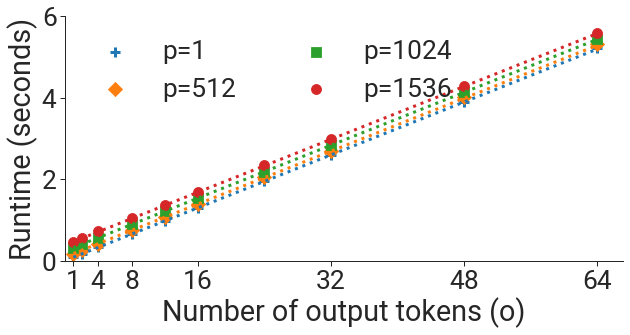

[(1, 0.087), (16, 0.089), (32, 0.091), (64, 0.092), (128, 0.095), (192, 0.103), (256, 0.109), (320, 0.135), (384, 0.142), (428, 0.176), (472, 0.175), (512, 0.179), (576, 0.217), (640, 0.225), (704, 0.249), (768, 0.254), (832, 0.287), (896, 0.293), (960, 0.316), (1024, 0.324), (1152, 0.362), (1280, 0.4), (1408, 0.435), (1536, 0.469), (1664, 0.512), (1792, 0.548), (1920, 0.582)]
R^2 score: 0.999


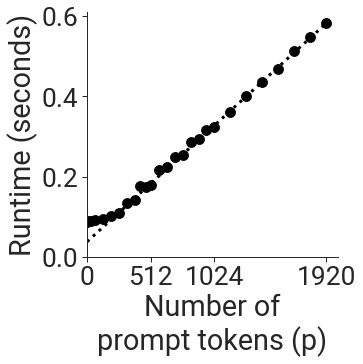

ai21_j1_grande


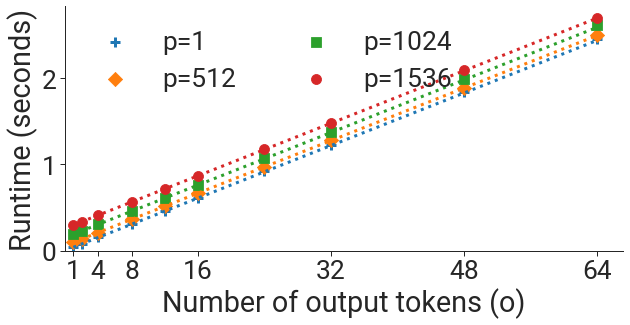

[(1, 0.041), (16, 0.043), (32, 0.04), (64, 0.041), (128, 0.042), (192, 0.053), (256, 0.057), (320, 0.077), (384, 0.081), (428, 0.096), (472, 0.096), (512, 0.098), (576, 0.118), (640, 0.122), (704, 0.146), (768, 0.149), (832, 0.168), (896, 0.172), (960, 0.188), (1024, 0.192), (1152, 0.223), (1280, 0.248), (1408, 0.279), (1536, 0.299), (1664, 0.328), (1792, 0.352), (1920, 0.38)]
R^2 score: 0.999


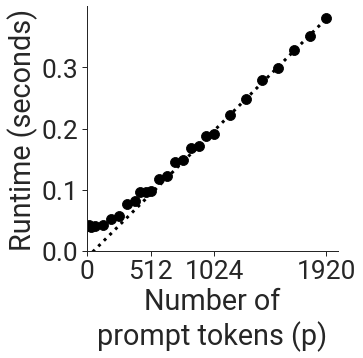

ai21_j1_jumbo


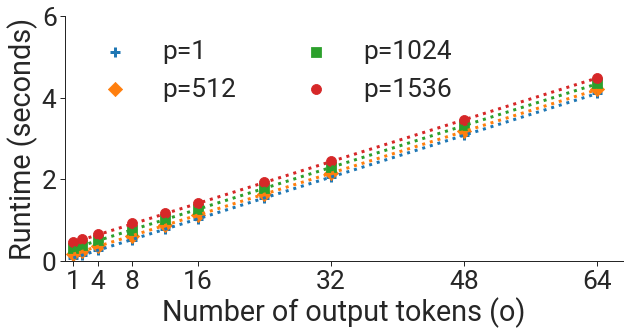

[(1, 0.07), (16, 0.071), (32, 0.073), (64, 0.073), (128, 0.078), (192, 0.091), (256, 0.097), (320, 0.133), (384, 0.14), (428, 0.158), (472, 0.161), (512, 0.165), (576, 0.198), (640, 0.209), (704, 0.237), (768, 0.244), (832, 0.269), (896, 0.275), (960, 0.3), (1024, 0.307), (1152, 0.355), (1280, 0.388), (1408, 0.424), (1536, 0.45), (1664, 0.499), (1792, 0.532), (1920, 0.58)]
R^2 score: 0.997


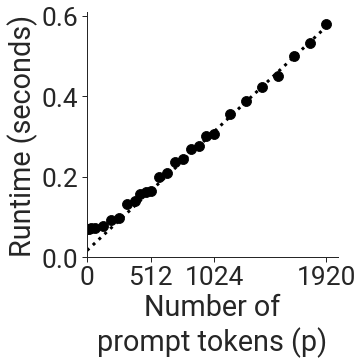

mt_nlg


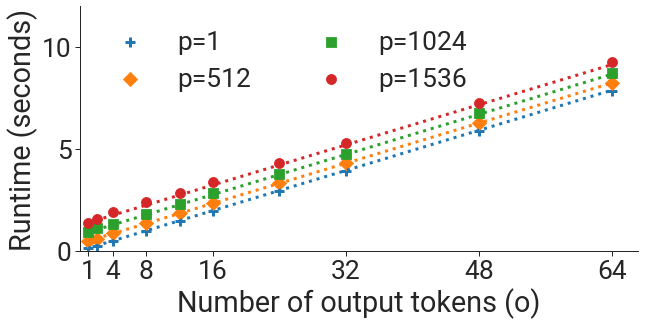

[(1, 0.129), (16, 0.135), (32, 0.14100000000000001), (64, 0.15000000000000002), (128, 0.17400000000000002), (192, 0.252), (256, 0.276), (320, 0.387), (384, 0.43199999999999994), (428, 0.45899999999999996), (472, 0.483), (512, 0.483), (576, 0.5640000000000001), (640, 0.591), (704, 0.7020000000000001), (768, 0.756), (832, 0.804), (896, 0.8280000000000001), (960, 0.8879999999999999), (1024, 0.9119999999999999), (1152, 1.0499999999999998), (1280, 1.173), (1408, 1.305), (1536, 1.383), (1664, 1.5870000000000002), (1792, 1.7519999999999998), (1920, 1.818)]
R^2 score: 0.993


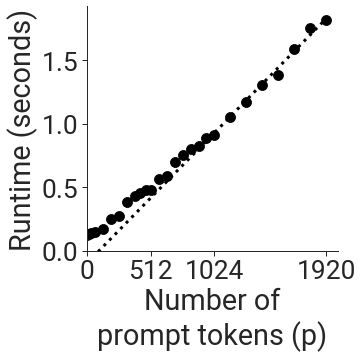

anthropic


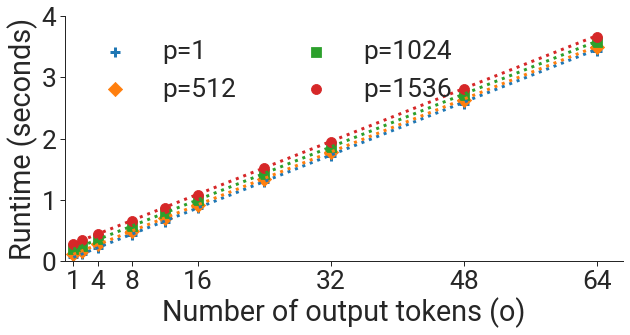

[(1, 0.057), (16, 0.06), (32, 0.057), (64, 0.057), (128, 0.06), (192, 0.059), (256, 0.066), (320, 0.078), (384, 0.082), (428, 0.104), (472, 0.107), (512, 0.107), (576, 0.121), (640, 0.125), (704, 0.145), (768, 0.149), (832, 0.172), (896, 0.175), (960, 0.182), (1024, 0.189), (1152, 0.211), (1280, 0.23), (1408, 0.255), (1536, 0.28), (1664, 0.297), (1792, 0.33), (1920, 0.342)]
R^2 score: 0.996


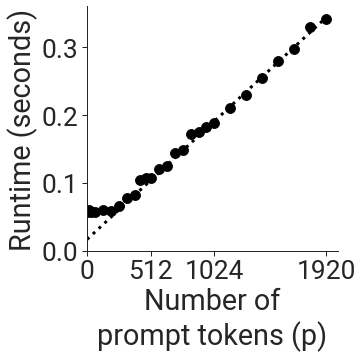

bloom


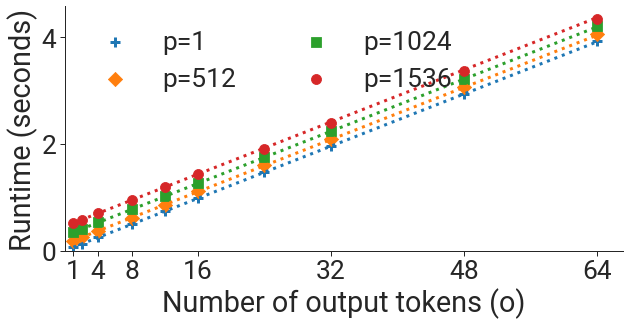

[(1, 0.068), (16, 0.069), (32, 0.07), (64, 0.072), (128, 0.082), (192, 0.095), (256, 0.112), (320, 0.142), (384, 0.15), (428, 0.185), (472, 0.186), (512, 0.192), (576, 0.214), (640, 0.22), (704, 0.259), (768, 0.267), (832, 0.302), (896, 0.312), (960, 0.341), (1024, 0.347), (1152, 0.393), (1280, 0.433), (1408, 0.483), (1536, 0.521), (1664, 0.577), (1792, 0.618), (1920, 0.668)]
R^2 score: 0.997


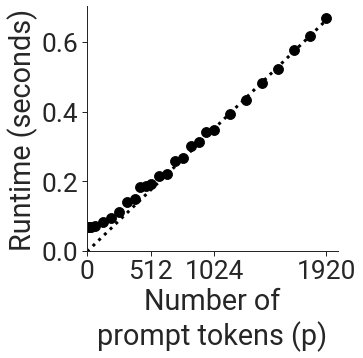

yalm


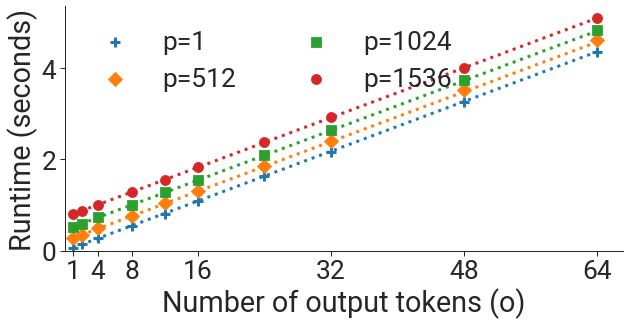

[(1, 0.072), (16, 0.074), (32, 0.07), (64, 0.106), (128, 0.111), (192, 0.147), (256, 0.168), (320, 0.217), (384, 0.229), (428, 0.28), (472, 0.276), (512, 0.284), (576, 0.331), (640, 0.347), (704, 0.397), (768, 0.415), (832, 0.477), (896, 0.487), (960, 0.509), (1024, 0.527), (1152, 0.589), (1280, 0.675), (1408, 0.772), (1536, 0.809), (1664, 0.863), (1792, 0.919), (1920, 1.007)]
R^2 score: 0.993


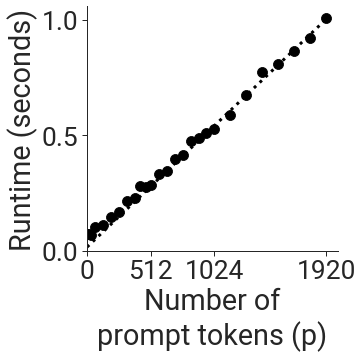

In [10]:
# Plot A100 runtimes on Megatron.
runtimes = a100_megatron_runtimes
plot_per_model_runtimes(runtimes, 'openai_davinci', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["openai/davinci"],
                        ylim=6.0,
                        output_filename='../figures/runtime_vs_num_output_tokens/openai_davinci.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_grande', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["ai21/j1-grande"],
                        output_filename='../figures/runtime_vs_num_output_tokens/ai21_j1_grande.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_jumbo', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["ai21/j1-jumbo"],
                        ylim=6.0,
                        output_filename='../figures/runtime_vs_num_output_tokens/ai21_j1_jumbo.pdf')
plot_per_model_runtimes(runtimes, 'mt_nlg', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["microsoft/TNLGv2_530B"],
                        ylim=12.0,
                        output_filename='../figures/runtime_vs_num_output_tokens/mt_nlg.pdf')
plot_per_model_runtimes(runtimes, 'anthropic', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["anthropic/stanford-online-all-v4-s3"],
                        ylim=4.0,
                        output_filename='../figures/runtime_vs_num_output_tokens/anthropic.pdf')
plot_per_model_runtimes(runtimes, 'bloom', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["together/bloom"],
                        output_filename='../figures/runtime_vs_num_output_tokens/bloom.pdf')
plot_per_model_runtimes(runtimes, 'yalm', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=megatron_json_obj["together/yalm"],
                        output_filename='../figures/runtime_vs_num_output_tokens/yalm.pdf')

ai21_j1_large


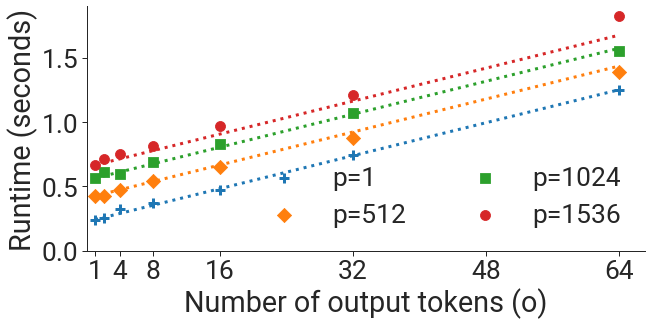

[(1, 0.2429361343383789), (256, 0.3292415142059326), (512, 0.42743873596191406), (1024, 0.5649175643920898), (1536, 0.6670892238616943)]
R^2 score: 0.985


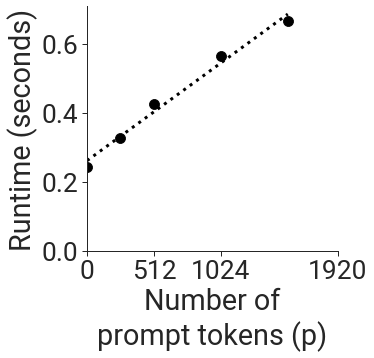

ai21_j1_grande


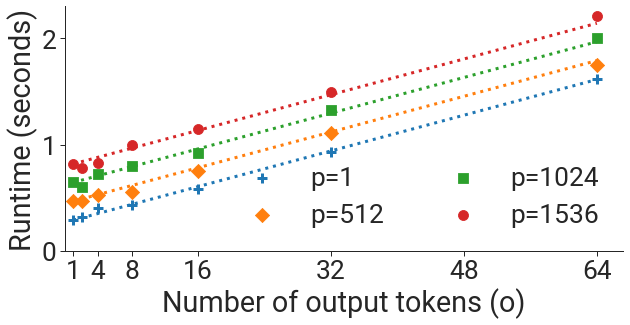

[(1, 0.2888600826263428), (256, 0.3305823802947998), (512, 0.46675729751586914), (1024, 0.6440958976745605), (1536, 0.8184366226196289)]
R^2 score: 0.992


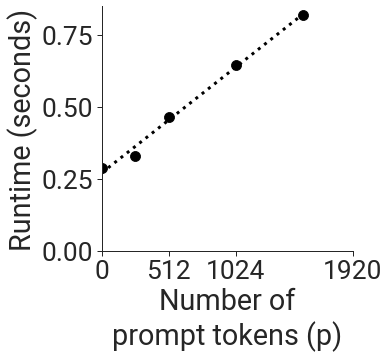

ai21_j1_jumbo


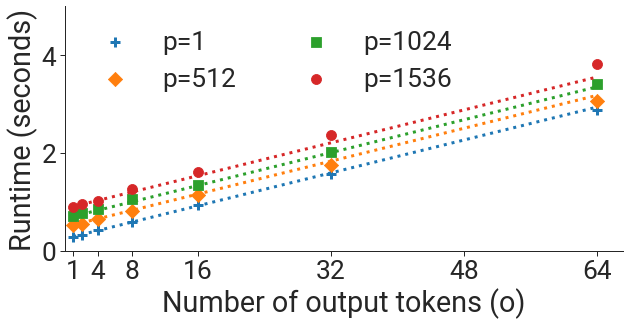

[(1, 0.29091906547546387), (256, 0.36374855041503906), (512, 0.530540943145752), (1024, 0.7052390575408936), (1536, 0.9059767723083496)]
R^2 score: 0.992


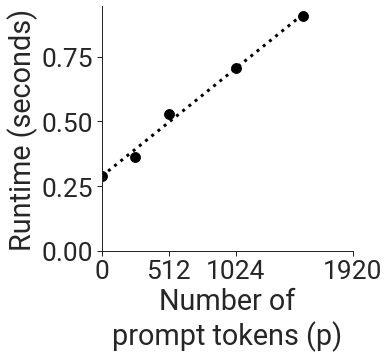

anthropic


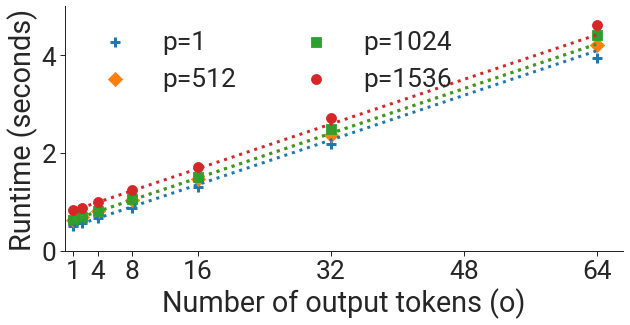

[(1, 0.49916529655456543), (256, 0.6275599002838135), (512, 0.6377735137939453), (1024, 0.6346790790557861), (1536, 0.8245017528533936)]
R^2 score: 0.810


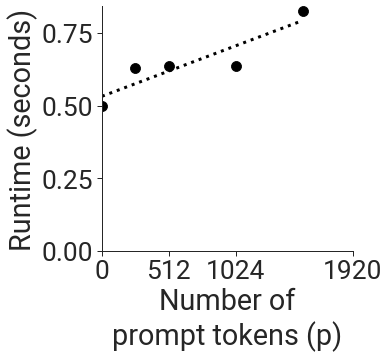

cohere_small-20220720


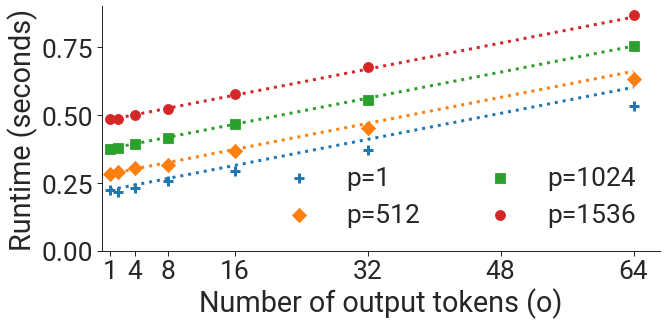

[(1, 0.22465801239013672), (256, 0.24055242538452148), (512, 0.2844386100769043), (1024, 0.3769979476928711), (1536, 0.48433876037597656)]
R^2 score: 0.984


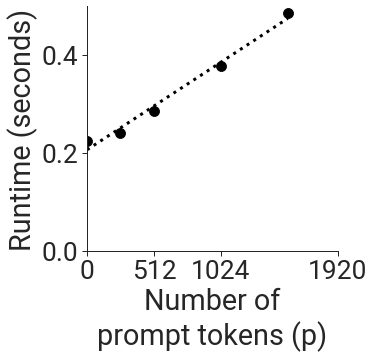

cohere_medium-20220720


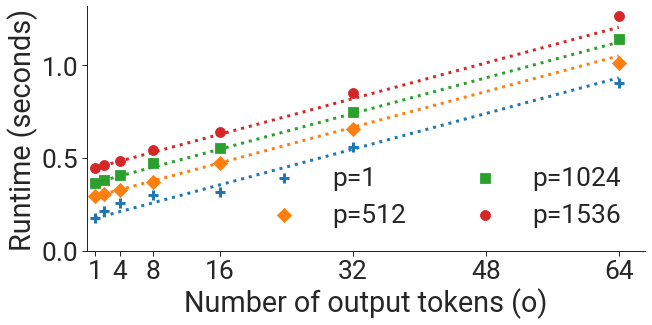

[(1, 0.17451882362365723), (256, 0.25691938400268555), (512, 0.29302144050598145), (1024, 0.3674936294555664), (1536, 0.447223424911499)]
R^2 score: 0.978


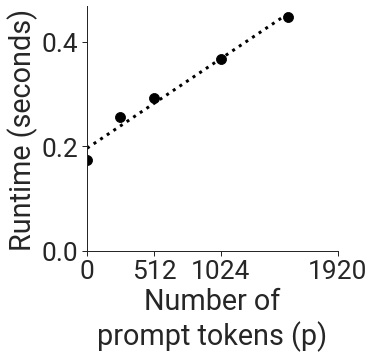

cohere_large-20220720


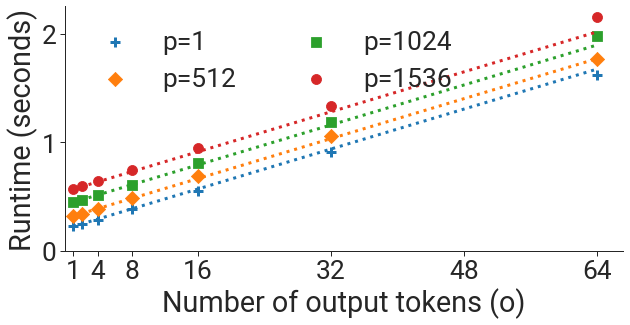

[(1, 0.22522759437561035), (256, 0.272036075592041), (512, 0.32123756408691406), (1024, 0.44733476638793945), (1536, 0.5683746337890625)]
R^2 score: 0.997


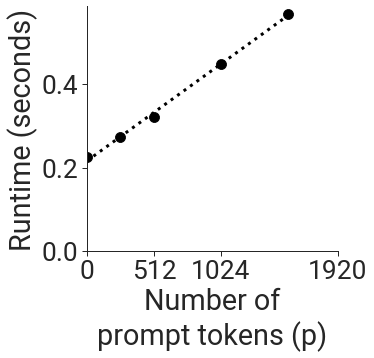

cohere_xlarge-20220609


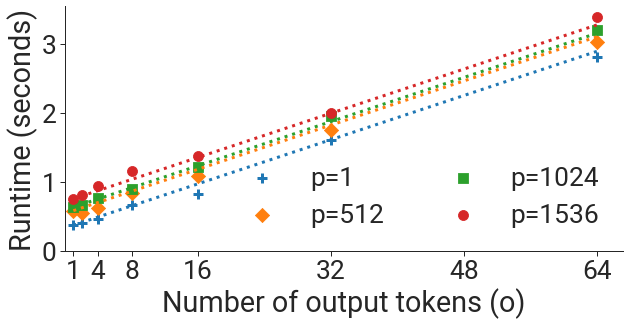

[(1, 0.3711252212524414), (256, 0.43314385414123535), (512, 0.5823078155517578), (1024, 0.6327831745147705), (1536, 0.7535943984985352)]
R^2 score: 0.943


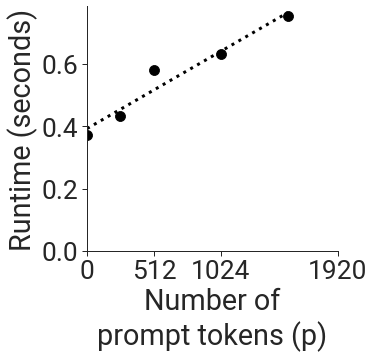

In [11]:
# Plot minimum black-box API runtimes.
runtimes = real_system_runtimes
plot_per_model_runtimes(runtimes, 'ai21_j1_large', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["ai21/j1-large"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_large_v3.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_grande', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["ai21/j1-grande"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_grande_v3.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_jumbo', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["ai21/j1-jumbo"],
                        ylim=5.0,
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_jumbo_v3.pdf')
plot_per_model_runtimes(runtimes, 'anthropic', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["anthropic/stanford-online-all-v4-s3"],
                        ylim=5.0,
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_anthropic_v3.pdf')
plot_per_model_runtimes(runtimes, 'cohere_small-20220720', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["cohere/small-20220720"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_cohere_small_v3.pdf')
plot_per_model_runtimes(runtimes, 'cohere_medium-20220720', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["cohere/medium-20220720"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_cohere_medium_v3.pdf')
plot_per_model_runtimes(runtimes, 'cohere_large-20220720', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["cohere/large-20220720"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_cohere_large_v3.pdf')
plot_per_model_runtimes(runtimes, 'cohere_xlarge-20220609', [1, 512, 1024, 1536],
                        scatter=True,
                        model_obj=real_system_json_obj["cohere/xlarge-20220609"],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_cohere_xlarge_v3.pdf')

In [12]:
def plot_per_model_runtimes(runtimes, model, all_num_prompt_tokens,
                            ylabel=None,
                            ylim=None,
                            output_filename=None):
    print(model)

    # Plot runtimes versus number of output tokens.
    plt.figure(figsize=(10, 4.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    markers = ['+', 'D', 's', 'o', '^']
    num_runtimes = None
    max_median = None
    for marker, num_prompt_tokens in zip(markers, all_num_prompt_tokens):
        num_output_tokens_and_runtimes = []
        for label, runtime in runtimes.items():
            if label[0] == model and label[1] == num_prompt_tokens:
                num_output_tokens_and_runtimes.append((label[2], runtime))
                num_runtimes = len(runtime)
        num_output_tokens_and_runtimes.sort()
        medians = []
        mins = []
        maxs = []
        for _, y in num_output_tokens_and_runtimes:
            medians.append(np.median(y))
            if max_median is None or medians[-1] > max_median:
                max_median = medians[-1]
            mins.append(np.min(y))
            maxs.append(np.max(y))
        ax.plot([x for (x, _) in num_output_tokens_and_runtimes],
                medians, label=f"p={num_prompt_tokens}",
                marker=marker, linestyle=':')
        ax.fill_between([x for (x, _) in num_output_tokens_and_runtimes], mins, maxs, alpha=0.2)
            
    ax.set_xticks([1, 4, 8, 16, 32, 48, 64])
    
    ax.set_xlim(0, None)
    if ylim is None:
        ax.set_ylim(0, min(10.0, max_median + 1.0))
    else:
        ax.set_ylim(0, ylim)
    ax.set_xlabel("Number of output tokens (o)")
    if ylabel is None:
        ax.set_ylabel("Runtime (seconds)")
    else:
        ax.set_ylabel(ylabel)
    plt.legend(frameon=False, ncol=2)
    sns.despine()
    
    if output_filename is not None:
        plt.savefig(output_filename, bbox_inches='tight')
    
    plt.show()

ai21_j1_large


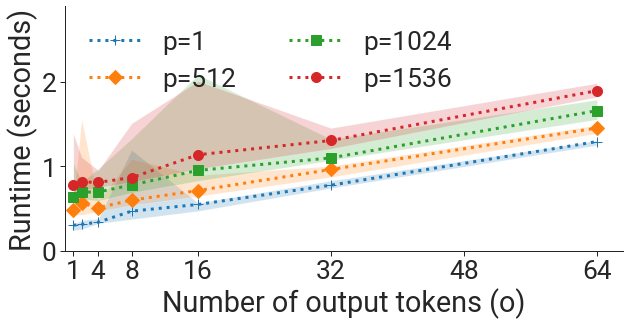

ai21_j1_grande


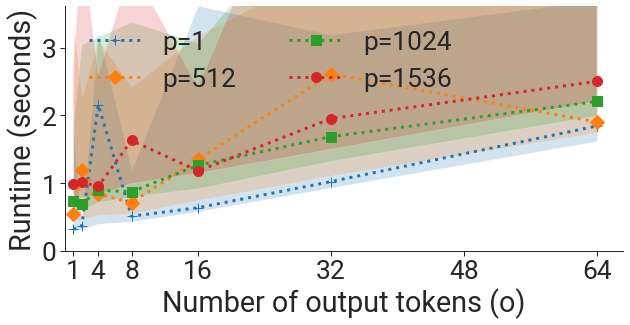

ai21_j1_jumbo


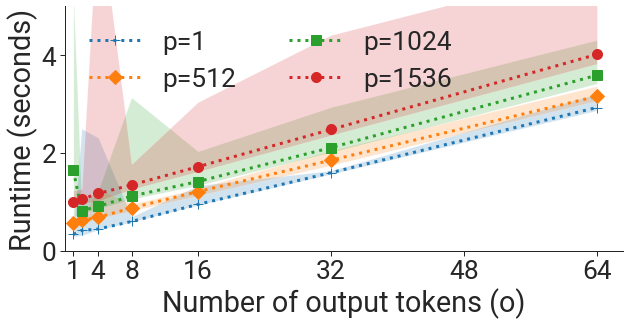

anthropic


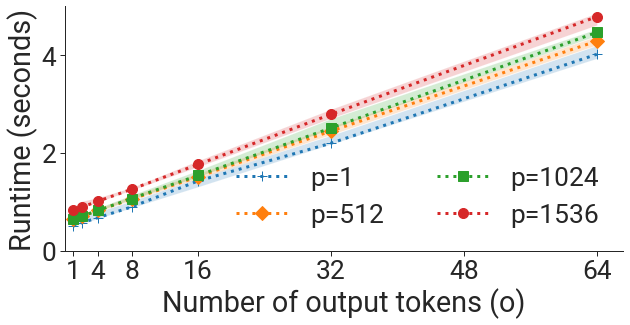

cohere_small-20220720


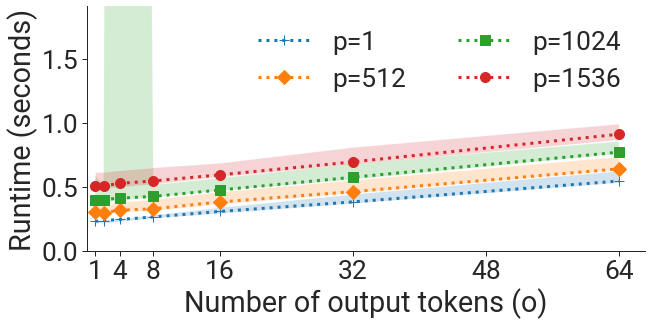

cohere_medium-20220720


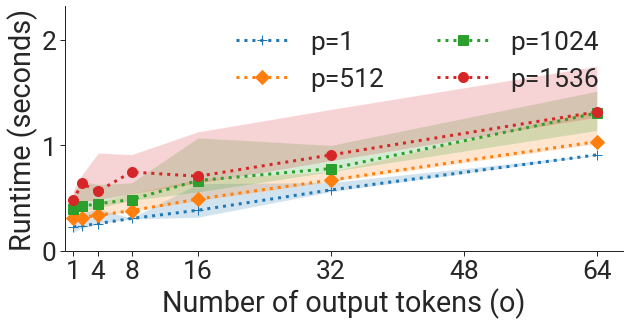

cohere_large-20220720


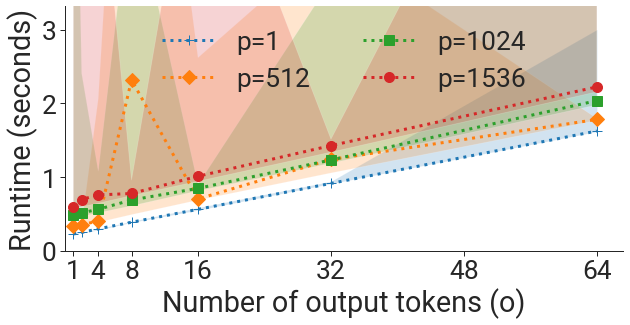

cohere_xlarge-20220609


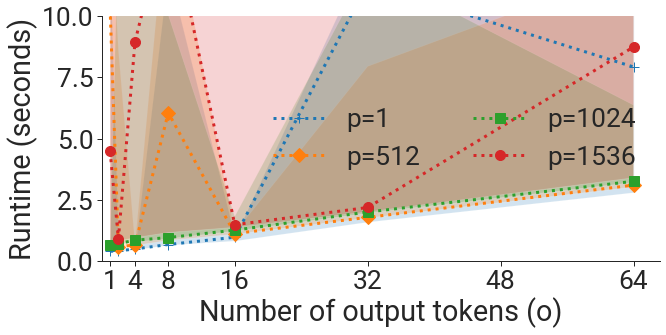

In [13]:
# Plot random black-box API runtimes.
runtimes = real_system_runtimes_random
plot_per_model_runtimes(runtimes, 'ai21_j1_large', [1, 512, 1024, 1536],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_large_v4.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_grande', [1, 512, 1024, 1536],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_grande_v4.pdf')
plot_per_model_runtimes(runtimes, 'ai21_j1_jumbo', [1, 512, 1024, 1536],
                        ylim=5.0,
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_ai21_j1_jumbo_v4.pdf')
plot_per_model_runtimes(runtimes, 'anthropic', [1, 512, 1024, 1536],
                        ylim=5.0,
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_anthropic_v4.pdf')
plot_per_model_runtimes(runtimes, 'cohere_small-20220720', [1, 512, 1024, 1536],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_cohere_small_v4.pdf')
plot_per_model_runtimes(runtimes, 'cohere_medium-20220720', [1, 512, 1024, 1536],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_cohere_medium_v4.pdf')
plot_per_model_runtimes(runtimes, 'cohere_large-20220720', [1, 512, 1024, 1536],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_cohere_large_v4.pdf')
plot_per_model_runtimes(runtimes, 'cohere_xlarge-20220609', [1, 512, 1024, 1536],
                        output_filename='../figures/runtime_vs_num_output_tokens/real_system_cohere_xlarge_v4.pdf')